In [1]:
import os, glob
import pandas as pd
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
import pdb
import scipy
from scipy.optimize import minimize, fmin
from scipy.stats import multivariate_normal
from tqdm.notebook import tqdm
import matplotlib
import pingouin as pg
import warnings
warnings.filterwarnings('ignore')


matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['tahoma']
def makeAxesPretty(ax):
    for axis in ['bottom','left']:
        ax.spines[axis].set_linewidth(2)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

In [2]:
# defining variables
expt_tones = np.arange(90,3000,1) #array of possible true tones
log_freq_seq_array = np.arange(0.6,4.7,0.1)
log_freq_percept = np.arange(0.6,4.7,0.1) # array of possible perceptual tones

def extractData(csv_test, csv_data, exptTotalLength, exptLengthWithBreaks):  
    n_tones=3
    n_trials = csv_data.shape[0]-47

    test_columns = list(csv_test.columns)
    test_tones_name = test_columns.index('Name')
    test_tones_col_idx = test_columns.index('Tones')
    test_toneKind_col_idx = test_columns.index('Tonekind')
    df_names = (csv_test.iloc[0:exptTotalLength,test_tones_name]).values
    df_tones = (csv_test.iloc[0:exptTotalLength,test_tones_col_idx]).values
    df_toneKind = (csv_test.iloc[0:exptTotalLength,test_toneKind_col_idx]).values

    tones_array_orig = np.zeros((n_trials,n_tones))
    toneKind_array_orig = np.zeros((n_trials,n_tones))
    tones_array_idxs_keep = []

    for i_wav in range(exptLengthWithBreaks):
        if isinstance(csv_data['Name'][i_wav+46],str):
            tones_array_orig[i_wav,:] = np.array(df_tones[np.where(csv_data['Name'][i_wav+46]
                                                                   ==df_names)[0]][0][1:-1].split(',')).astype(float)  
            toneKind_array_orig[i_wav,:] = np.array(df_toneKind[np.where(csv_data['Name'][i_wav+46]
                                                                          ==df_names)[0]][0][1:-1].split(',')).astype(float)  
            tones_array_idxs_keep += [i_wav]


    exptTones = np.copy(tones_array_orig[tones_array_idxs_keep,:])
    exptToneKind = np.copy(toneKind_array_orig[tones_array_idxs_keep,:])
    exptCorrans = np.copy(csv_data['corrAns'][46:csv_data.shape[0]])[tones_array_idxs_keep]
    exptKeys = np.copy(csv_data['test_resp.keys'][46:csv_data.shape[0]])[tones_array_idxs_keep]
    
    return exptTones, exptToneKind, exptCorrans, exptKeys

def identifyResponseTrials(tonesPlayed,tonesSignalOrDistractor,correctAns,keysPressed,
                           exptTotalLength, printText=0):
    no_response = np.intersect1d(np.where(keysPressed!='h')[0],
                                 np.where(keysPressed!='l')[0])
    #print("Did not respond to: ",no_response)

    """
    Convert keys ['l','h'] to [0,1]
    """

    corrans_num_orig = np.zeros_like(correctAns)
    corrans_num_orig[correctAns == 'h'] = 1

    keys_num_orig = np.zeros_like(keysPressed)
    keys_num_orig[keysPressed == 'h'] = 1

    corrans_num = corrans_num_orig[:exptTotalLength]
    keys_num = keys_num_orig[:exptTotalLength]
    tones_array = tonesPlayed[:exptTotalLength]
    tonesType_array = tonesSignalOrDistractor[:exptTotalLength]

    trial_tones = np.repeat(tones_array,1,axis = 0)
    trial_behaviour = np.reshape(keys_num,np.prod(keys_num.shape)) 
    idxs_with_response = np.delete(np.arange(len(trial_tones)),no_response)
    trialTonesResponded = trial_tones[idxs_with_response,:]
    trialBehaviourResponded = trial_behaviour[idxs_with_response]
    corransResponded = corrans_num[idxs_with_response]
    tonesTypeResponded = tonesType_array[idxs_with_response]
    
    """
    Using data to constrain the plow parameter
    """   
    idxHigh = np.arange(len(trialBehaviourResponded))[corransResponded==1]
    idxLow = np.arange(len(trialBehaviourResponded))[corransResponded==0]
    idxToKeep = np.concatenate((idxHigh, np.random.choice(idxLow,size=len(idxLow),replace=False)))
    if printText:
        print(f"Total trials played are {len(trial_tones)}, and total trials responded to are {len(trialTonesResponded)}")
        print("Got correct: ", np.sum(trialBehaviourResponded==corransResponded)/len(trialTonesResponded))
        print("No. of minority category correct: ", np.sum(keys_num*corrans_num)/np.sum(corrans_num))
        print("Majority category accuracy - minority category accuracy",
              -np.sum((1-keys_num)*(1-corrans_num))/np.sum(1-corrans_num)
              +np.sum((keys_num)*(corrans_num))/np.sum(corrans_num))
        print("probability of low given the data is likely to be: ", 1-sum(trial_behaviour[idxToKeep])/len(idxToKeep))
    
    return trialTonesResponded, tonesTypeResponded, corransResponded, trialBehaviourResponded 

def plottingInfluenceFn(tones, behaviour):
    unique_tones = np.unique(tones)

    tone1_prob_behaviour = np.zeros((len(unique_tones),1))
    tone2_prob_behaviour = np.zeros((len(unique_tones),1))
    tone3_prob_behaviour = np.zeros((len(unique_tones),1))
    
    for i_tone in range(len(unique_tones)):
        tone1_prob_behaviour[i_tone] = np.mean(behaviour[tones[:,0]==unique_tones[i_tone]])
        tone2_prob_behaviour[i_tone] = np.mean(behaviour[tones[:,1]==unique_tones[i_tone]])
        tone3_prob_behaviour[i_tone] = np.mean(behaviour[tones[:,2]==unique_tones[i_tone]])
    behaviour = np.concatenate((tone1_prob_behaviour,tone2_prob_behaviour,tone3_prob_behaviour),axis=1)
    return unique_tones, behaviour  


In [3]:
def gaussian(x, mean, sigma):
    return np.exp(-(x-mean)**2/(2*sigma**2))

def Tones3dgrid(latentTones, sigma):
    
    input_array_0 = np.expand_dims(gaussian(log_freq_percept, latentTones[0], sigma), axis = 1)
    input_array_1 = np.expand_dims(gaussian(log_freq_percept, latentTones[1], sigma), axis = 1)
    input_array_2 = np.expand_dims(gaussian(log_freq_percept, latentTones[2], sigma), axis = 1)
    s0 = 1/np.sum(input_array_0); s1 = 1/np.sum(input_array_1); s2 = 1/np.sum(input_array_2)
    input_array_0 *= s0; input_array_1 *= s1; input_array_2 *= s2; 
    
    input_array_mat = np.expand_dims(input_array_0@input_array_1.T,axis=2)@(input_array_2.T) #p(T1,T2..|H)     
    
    return input_array_mat

def posterior_array(freq_input, n_tones, p_back, log_prior):
    """
    Arguments: 
    freq_input - range of all possible frequencies (percepts?)
    p_back - prob of background
    p_low - prob of low condition
    log_prior - list of prior parameters
    """
    
    log_prior_low_mean = log_prior[0]; log_prior_low_sigma = log_prior[2];
    log_prior_high_mean = log_prior[1]; log_prior_high_sigma = log_prior[2];
    likelihood_onetone_low = gaussian(x=freq_input, mean=log_prior_low_mean, sigma=log_prior_low_sigma)
    likelihood_onetone_high = gaussian(x=freq_input, mean=log_prior_high_mean, sigma=log_prior_high_sigma)
    likelihood_onetone_mixed_high = p_back*(1/len(freq_input)) + (1-p_back)*likelihood_onetone_high \
    #mixture model with p(T|B) = 1/no. of possible freqs
    likelihood_onetone_mixed_high /= likelihood_onetone_mixed_high.sum() #normalizing
    likelihood_onetone_mixed_high = np.expand_dims(likelihood_onetone_mixed_high, axis = 1)
    likelihood_onetone_mixed_low = p_back*(1/len(freq_input)) + (1-p_back)*likelihood_onetone_low \
    #mixture model with p(T|B) = 1/no. of possible freqs
    likelihood_onetone_mixed_low /= likelihood_onetone_mixed_low.sum() #normalizing
    likelihood_onetone_mixed_low = np.expand_dims(likelihood_onetone_mixed_low, axis = 1)
        
    if n_tones == 3:
        likelihood_alltones_low = (np.expand_dims(likelihood_onetone_mixed_low@np.transpose
                                                 (likelihood_onetone_mixed_low),axis=2)
                                   @np.transpose(likelihood_onetone_mixed_low))
        #p(T1,T2..|L) 
        likelihood_alltones_high = (np.expand_dims(likelihood_onetone_mixed_high@np.transpose
                                                 (likelihood_onetone_mixed_high),axis=2)
                                    @np.transpose(likelihood_onetone_mixed_high))
        #p(T1,T2..|H) 
    elif n_tones == 1:
        likelihood_alltones_low = likelihood_onetone_mixed_low
        likelihood_alltones_high = likelihood_onetone_mixed_high

    return [likelihood_onetone_mixed_high, likelihood_onetone_mixed_low, 
            likelihood_alltones_high, likelihood_alltones_low]


In [4]:
def localVsGlobalEffectCorrectness(tones,corrAns,behaviour):
    
    trialIdxs = np.arange(len(corrAns)-1)
    trialIdxsCategory = np.copy(trialIdxs)#[corrAns[:-1] == 1]
    
    """
    Prev trial is correctly classified
    """

    correctResponseIdx = trialIdxs[corrAns[:-1] == behaviour[:-1]]
    correctResponseIdxOfInterest = np.intersect1d(trialIdxsCategory, correctResponseIdx)
    trialsSucceedingCorrectResp = tones[correctResponseIdxOfInterest+1,:]
    behaviourSucceedingCorrectResp = behaviour[correctResponseIdxOfInterest+1]
    corransSucceedingCorrectResp = corrAns[correctResponseIdxOfInterest+1]
    
    
    [unique_tonesPlayed_CorrectResp, 
    subjectBehaviourPrevTrialCorrectResp] = plottingInfluenceFn(trialsSucceedingCorrectResp,
                                                               behaviourSucceedingCorrectResp)
    
    """
    Prev trial is incorrectly classified
    """
    incorrectResponseIdx = trialIdxs[corrAns[:-1] != behaviour[:-1]]
    incorrectResponseIdxOfInterest = np.intersect1d(trialIdxsCategory, incorrectResponseIdx)
    trialsSucceedingIncorrectResp = tones[incorrectResponseIdxOfInterest+1,:]
    behaviourSucceedingIncorrectResp = behaviour[incorrectResponseIdxOfInterest+1]
    corransSucceedingIncorrectResp = corrAns[incorrectResponseIdxOfInterest+1]
    
    [unique_tonesPlayed_IncorrectResp, 
    subjectBehaviourPrevTrialIncorrectResp] = plottingInfluenceFn(trialsSucceedingIncorrectResp,
                                                                 behaviourSucceedingIncorrectResp)
    
    return [unique_tonesPlayed_CorrectResp, unique_tonesPlayed_IncorrectResp, 
            subjectBehaviourPrevTrialCorrectResp, subjectBehaviourPrevTrialIncorrectResp]


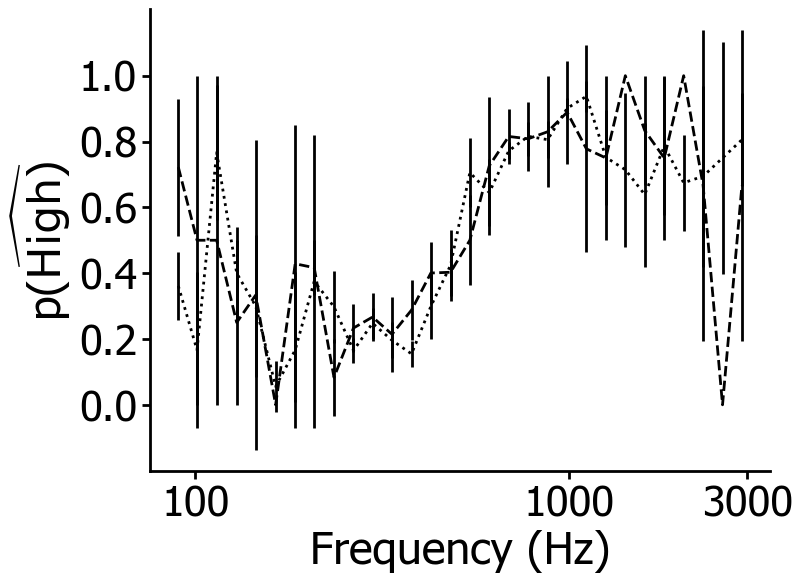

In [5]:
""" 
Short-term context plots for an individual participant
"""
fig1, ax1 = plt.subplots(1,1,figsize=(8,6))

Test = pd.read_csv('subjectDataForPlots/allTrials_noBias.csv')
Data = pd.read_csv('subjectDataForPlots/noContextData/5ec3a1fe1bfa1720b3731604_categorization_task_2021-03-01_21h58.03.550.csv');

df_tones, df_toneKind, df_corrans, df_keys = extractData(csv_test=Test, 
                                                        csv_data=Data, 
                                                        exptTotalLength=600, 
                                                        exptLengthWithBreaks=603) 

[trial_tones, _, trial_corrans, trial_behaviour] = identifyResponseTrials(keysPressed = df_keys,
                                                                        correctAns = df_corrans, 
                                                                        tonesPlayed = df_tones, 
                                                                        tonesSignalOrDistractor = df_toneKind,
                                                                        exptTotalLength = 600)

unique_tones_played, subjectBehaviourExperimental = plottingInfluenceFn(trial_tones, 
                                                                        trial_behaviour) 

[uniqueTones_CorrectResp, uniqueTones_IncorrectResp, 
 meanBehaviourAfterCorrectResp, 
 meanBehaviourAfterIncorrectResp] = localVsGlobalEffectCorrectness(tones=trial_tones,
                                                                   corrAns=trial_corrans,
                                                                   behaviour=trial_behaviour)

ax1.errorbar(np.log10(uniqueTones_CorrectResp), np.nanmean(meanBehaviourAfterCorrectResp,axis=1), 
             yerr=np.nanstd(meanBehaviourAfterCorrectResp,axis=1),
             color='black',linestyle='dotted',linewidth=2)
ax1.errorbar(np.log10(uniqueTones_IncorrectResp), np.nanmean(meanBehaviourAfterIncorrectResp,axis=1), 
             yerr=np.nanstd(meanBehaviourAfterIncorrectResp,axis=1),
             color='black',linestyle='dashed',linewidth=2) 


for ax in [ax1]:
    ax.set_xticks(ticks=np.log10([100,1000,3000]))
    ax.set_xticklabels(labels=[100,1000,3000])
    ax.set_yticks(ticks=np.arange(0,1.1,0.2))
    ax.set_yticklabels(labels=np.around(np.arange(0,1.1,0.2),1))
    ax.tick_params(axis='both',labelsize=30,length=6,width=2)
    ax.set_xlabel('Frequency (Hz)',fontsize=32)
    ax.set_ylabel(r'p($\rm{\widehat{High}}$)',fontsize=32)
    makeAxesPretty(ax)




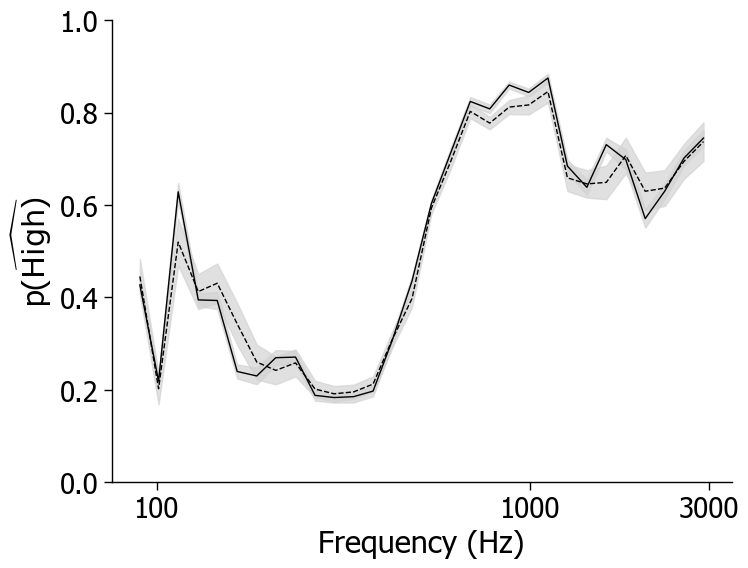

In [6]:
"""
Fig. S7A: Short-term context plots for the population -- category choice versus correctness of previous trial
"""

Test = pd.read_csv('subjectDataForPlots/allTrials_noBias.csv')
SubjectFiles = os.listdir('subjectDataForPlots/noContextData')
subjectBehaviourAfterCorrectResp = np.zeros((56,30))
subjectBehaviourAfterIncorrectResp = np.zeros((56,30))
idx = 0
for subjectIdx in range(56): 
    if subjectIdx not in []:#[2,18,19,20,21,23,24,25,26,27,34,50,53]:
        filename = 'subjectDataForPlots/noContextData/'+SubjectFiles[subjectIdx]  
        Data = pd.read_csv(filename);
        df_noTones, df_noToneKind, df_noCorrans, df_noKeys = extractData(csv_test=Test, 
                                                                        csv_data=Data, 
                                                                        exptTotalLength=600, 
                                                                        exptLengthWithBreaks=603) 

        [noTones, noToneTypes, noCorrans, noBehaviour] = identifyResponseTrials(keysPressed = df_noKeys,
                                                                                correctAns = df_noCorrans, 
                                                                                tonesPlayed = df_noTones, 
                                                                                tonesSignalOrDistractor = df_noToneKind,
                                                                                exptTotalLength = 600)  

        [uniqueTones_CorrectResp, uniqueTones_IncorrectResp,
         meanBehaviourAfterCorrectResp,
         meanBehaviourAfterIncorrectResp] = localVsGlobalEffectCorrectness(tones=noTones,
                                                                           corrAns=noCorrans,
                                                                           behaviour=noBehaviour)

        subjectBehaviourAfterCorrectResp[idx,:] = np.nanmean(meanBehaviourAfterCorrectResp,axis=1)
        subjectBehaviourAfterIncorrectResp[idx,
            np.where(np.in1d(uniqueTones_CorrectResp, 
                             uniqueTones_IncorrectResp))[0]] = np.nanmean(meanBehaviourAfterIncorrectResp,axis=1)
        idx += 1
        

fig, ax = plt.subplots(1,1,figsize=(8,6))   

ax.plot(np.log10(uniqueTones_CorrectResp), np.nanmean(subjectBehaviourAfterCorrectResp,axis=0),
        color='k',linewidth=1)
ax.fill_between(np.log10(uniqueTones_CorrectResp),
                y1 = np.nanmean(subjectBehaviourAfterCorrectResp,axis=0) - 
                np.nanstd(subjectBehaviourAfterCorrectResp,axis=0)/np.sqrt(56),
                y2 = np.nanmean(subjectBehaviourAfterCorrectResp,axis=0) + 
                np.nanstd(subjectBehaviourAfterCorrectResp,axis=0)/np.sqrt(56),
                color='lightgray',alpha=0.7)

ax.plot(np.log10(uniqueTones_CorrectResp), np.nanmean(subjectBehaviourAfterIncorrectResp,axis=0),
        color='k', linestyle = 'dashed', linewidth=1)
ax.fill_between(np.log10(uniqueTones_CorrectResp),
                y1 = np.nanmean(subjectBehaviourAfterIncorrectResp,axis=0) - 
                np.nanstd(subjectBehaviourAfterIncorrectResp,axis=0)/np.sqrt(56),
                y2 = np.nanmean(subjectBehaviourAfterIncorrectResp,axis=0) + 
                np.nanstd(subjectBehaviourAfterIncorrectResp,axis=0)/np.sqrt(56),
                color='lightgray',alpha=0.7)


ax.set_xticks(ticks=np.log10([100,1000,3000]))
ax.set_xticklabels(labels=[100,1000,3000])
ax.set_yticks(ticks=np.arange(0,1.1,0.2))
ax.set_yticklabels(labels=np.around(np.arange(0,1.1,0.2),1))
ax.tick_params(axis='both',labelsize=20,length=6,width=1)
ax.set_xlabel('Frequency (Hz)',fontsize=22)
ax.set_ylabel(r'p($\rm{\widehat{High}}$)',fontsize=22)
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#fig.savefig('figures/FromProlific/illustrations/localBiasDueToCorrectnessOfTrial_allSubjects.pdf',
#            bbox_inches='tight',transparent=True)
    

In [ ]:
subjectBehaviourAfterCorrectResp

In [ ]:
"""
Stats for delta parameter for correctness. Delta quantifies the effect of the previous trial.
"""

print("Short-term learning in no context")
print(np.mean(subjectBehaviourAfterCorrectResp[:,13:17],axis=1) - 
      np.mean(subjectBehaviourAfterIncorrectResp[:,13:17],axis=1),
      np.mean(np.mean(subjectBehaviourAfterCorrectResp[:,13:17],axis=1) - 
              np.mean(subjectBehaviourAfterIncorrectResp[:,13:17],axis=1)))

print("Wilcoxon test on short-term learning delta", 
      pg.wilcoxon(np.mean(subjectBehaviourAfterCorrectResp[:,13:17],axis=1) - 
      np.mean(subjectBehaviourAfterIncorrectResp[:,13:17],axis=1)))

shortTermLearning_dict = {"behaviourAfterCorrectTrialNC": subjectBehaviourAfterCorrectResp,
                         "behaviourAfterIncorrectTrialNC": subjectBehaviourAfterIncorrectResp}

#scipy.io.savemat("shortTermLearning_effectOfCorrectnessOnBehavior_HighCategory.mat", shortTermLearning_dict)

In [ ]:
plt.hist(np.mean(subjectBehaviourAfterCorrectResp[:,13:17],axis=1) - 
      np.mean(subjectBehaviourAfterIncorrectResp[:,13:17],axis=1))

expt_freq_seq = np.arange(90,3000,1)
expt_log_freq_seq_array = np.arange(np.log10(expt_freq_seq[0]), np.log10(expt_freq_seq[-1]), 
                                    np.log10(1003/1000)*40)

print(10**(np.mean(expt_log_freq_seq_array[13:17])))